# Block Group Preliminary Modeling

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import pipeline_jmidkiff as pipeline
import matplotlib.pyplot as plt # Don't overwrite plt !
from sklearn.metrics import (plot_confusion_matrix, 
    accuracy_score, precision_score, recall_score, make_scorer)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline as pipe_sklearn
import matplotlib.pyplot as plt # Don't overwrite plt !
import seaborn as sns
%matplotlib inline
sns.set_theme()

import warnings
# Many models give warnings which would be cumbersome to print
warnings.filterwarnings('ignore') 

In [2]:
# Importing final_df from 'Final Notebook': 
water_clean = pd.read_csv('data/final_df.csv', index_col=0)
high_block_groups = water_clean['threshold_high'].sum()
medium_block_groups = water_clean['threshold_medium'].sum()
print(f'''
Of the total {water_clean.shape[0]} block groups with any lead test results, 
{high_block_groups} block groups had at least 
one residence with a sample test result at or 
above 15.0 lead ppb - this was {round(high_block_groups / water_clean.shape[0] * 100, 1)}%.

{medium_block_groups} block groups had at least 
one residence with a sample test result at or 
above 5.0 lead ppb - this was {round(medium_block_groups / water_clean.shape[0] * 100, 1)}%.
''')

pipeline.show(water_clean)

# All block groups with a 'threshold_high' classification also 
# have a 'threshold_medium' classification. 


Of the total 2053 block groups with any lead test results, 
542 block groups had at least 
one residence with a sample test result at or 
above 15.0 lead ppb - this was 26.4%.

1521 block groups had at least 
one residence with a sample test result at or 
above 5.0 lead ppb - this was 74.1%.


Shape:
(2053, 60)

Data Types:
hh_size                                                          float64
med_income                                                       float64
occ_units                                                        float64
med_rent                                                         float64
oo_hsng_units                                                    float64
perc_white                                                       float64
perc_non_white                                                   float64
perc_black                                                       float64
perc_owner_occ                                                   float64
tot_pop         

,hh_size,med_income,occ_units,med_rent,oo_hsng_units,perc_white,perc_non_white,perc_black,perc_owner_occ,tot_pop,...,Roof Material_nan,Repair Condition_1.0,Repair Condition_2.0,Repair Condition_3.0,Repair Condition_nan,Renovation_1.0,Renovation_2.0,Renovation_nan,threshold_high,threshold_medium
0,1.95,55160.5,236.0,873.0,117.0,0.574837,0.425163,0.234273,0.495763,461.0,...,0.801619,0.004049,0.190283,0.004049,0.801619,0.000000,0.0,1.000000,0,1
2,1.50,54297.0,1073.0,1071.0,327.0,0.663361,0.336639,0.249125,0.304753,1714.0,...,0.924528,0.006289,0.069182,0.000000,0.924528,0.002096,0.0,0.997904,0,0
3,2.30,42778.0,712.0,1097.0,224.0,0.280774,0.719226,0.436694,0.314607,1706.0,...,0.625442,0.000000,0.371025,0.003534,0.625442,0.000000,0.0,1.000000,0,1
4,2.69,39535.0,1424.0,1152.0,353.0,0.542930,0.457070,0.300637,0.247893,3925.0,...,0.787551,0.000000,0.211096,0.001353,0.787551,0.000000,0.0,1.000000,0,1
5,2.99,52948.0,611.0,1023.0,114.0,0.465461,0.534539,0.326206,0.186579,1824.0,...,0.694190,0.000000,0.305810,0.000000,0.694190,0.000000,0.0,1.000000,0,1


In [3]:
water_classification = pipeline.impute_missing(water_clean)
# Of note, all property class 299 (condominiums) have NaN for building square feet, 
# but many other property classes do as well. 
# Total Building Square Feet was unfortunately all NaN for Property Class 299, despite 
# what the documentation said. 

Contains NA Values:
hh_size                                                          False
med_income                                                       False
occ_units                                                        False
med_rent                                                         False
oo_hsng_units                                                    False
perc_white                                                       False
perc_non_white                                                   False
perc_black                                                       False
perc_owner_occ                                                   False
tot_pop                                                          False
('PIN', 'count')                                                 False
('Prior Tax Year Market Value Estimate (Land)', 'mean')          False
('Prior Tax Year Market Value Estimate (Land)', 'median')        False
('Prior Tax Year Market Value Estimate (Building)', 'mean

In [4]:
scaler = pipeline.normalized_values(
    water_classification, ignore=['threshold_high', 'threshold_medium'], quiet=True)
water_classification = pipeline.normalize(
    water_classification, scaler, ignore=['threshold_high', 'threshold_medium'], 
    inplace=True)
water_classification

,threshold_high,threshold_medium,hh_size,med_income,occ_units,med_rent,oo_hsng_units,perc_white,perc_non_white,perc_black,...,Roof Material_5.0,Roof Material_6.0,Roof Material_nan,Repair Condition_1.0,Repair Condition_2.0,Repair Condition_3.0,Repair Condition_nan,Renovation_1.0,Renovation_2.0,Renovation_nan
0,0,1,-1.005069,-0.255313,-0.852549,-0.758570,-0.660678,0.296896,-0.296896,-0.271678,...,0.276038,-0.406439,1.660715,0.024643,-1.650931,-0.207227,1.660715,-0.417538,-0.022076,0.417348
2,0,0,-1.658708,-0.279086,1.887661,-0.212882,0.592835,0.559884,-0.559884,-0.234747,...,-0.417102,-0.406439,2.044203,0.235293,-2.028067,-0.556948,2.044203,0.017115,-0.022076,-0.016810
3,0,1,-0.496683,-0.596218,0.705802,-0.141226,-0.021984,-0.576720,0.576720,0.231678,...,-0.417102,-0.406439,1.111021,-0.355965,-1.088062,-0.251715,1.111021,-0.417538,-0.022076,0.417348
4,0,1,0.069804,-0.685502,3.036781,0.010354,0.748032,0.202104,-0.202104,-0.106652,...,-0.069594,-0.230854,1.616819,-0.355965,-1.586116,-0.440059,1.616819,-0.417538,-0.022076,0.417348
5,0,1,0.505563,-0.316226,0.375143,-0.345170,-0.678586,-0.028045,0.028045,-0.043070,...,-0.417102,0.188779,1.325522,-0.355965,-1.291154,-0.556948,1.325522,-0.417538,-0.022076,0.417348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2186,0,1,-0.554785,-0.902998,-0.557903,-0.593210,0.031738,-1.410855,1.410855,1.605485,...,0.947087,0.627486,-0.753408,-0.355965,0.697008,1.852083,-0.753408,-0.417538,-0.022076,0.417348
2188,0,0,-0.903392,-0.255313,-0.927848,-0.846762,-1.197898,-1.333016,1.333016,1.567288,...,-0.417102,-0.406439,0.258206,-0.355965,-0.225849,-0.556948,0.258206,2.502594,-0.022076,-2.499459
2189,0,0,-2.065416,-0.835712,0.470085,-0.124690,0.497329,-1.039025,1.039025,1.162417,...,-0.209831,-0.406439,2.264573,-0.355965,-2.228436,-0.556948,2.264573,-0.417538,-0.022076,0.417348
2190,0,0,-1.440828,-0.255313,-0.580820,-1.116850,-0.415945,-1.326135,1.326135,1.429157,...,-0.417102,-0.406439,1.828089,-0.355965,-1.854239,1.147940,1.828089,-0.417538,-0.022076,0.417348


In [5]:
# Split training and test data for both the 'high' and 'medium' categorizations
training, test = train_test_split(
    water_classification, test_size=0.2, random_state=0)
training_high_x, training_high_y = (
    training.drop(columns=['threshold_high', 'threshold_medium']),
    training['threshold_high'])
test_high_x, test_high_y = (
    test.drop(columns=['threshold_high', 'threshold_medium']), 
    test['threshold_high'])
training_med_x, training_med_y = (
    training.drop(columns=['threshold_high', 'threshold_medium']),
    training['threshold_medium'])
test_med_x, test_med_y = (
    test.drop(columns=['threshold_high', 'threshold_medium']), 
    test['threshold_medium'])

In [6]:
# Creating the pipeline and the grid of parameters to apply to the Logistic 
# regressions, with 10-fold validation
pipe = pipe_sklearn([
    ('LogisticRegression', LogisticRegression(max_iter=5000))
])
params = {
    'LogisticRegression__penalty': ['l1', 'l2', 'none'], 
    'LogisticRegression__solver': ['lbfgs', 'liblinear'],
    'LogisticRegression__C': [1000, 100, 10, 1, 0.1, 0.01, 0.001], 
    'LogisticRegression__class_weight': [None, 'balanced']
}
k = 10

## Logistic Classification of High (15.0+) Lead PBB Test Results

In [50]:
grid_model_high = GridSearchCV(estimator=pipe, 
                          param_grid=params, 
                          cv=10, 
                          scoring=['accuracy', 'precision', 'recall'], 
                          refit='recall')
grid_model_high_result = grid_model_high.fit(training_high_x, training_high_y)

In [59]:
p_high = grid_model_high_result.best_params_
test_score = grid_model_high_result.score(
    X=test_high_x,
    y=test_high_y)
print(f'''
The best model was a Logistic Regression with the following parameters: 
C: {p_high['LogisticRegression__C']}
Penalty: {p_high['LogisticRegression__penalty']}
Solver: {p_high['LogisticRegression__solver']}
Class Weight: {p_high['LogisticRegression__class_weight']}

It had a mean validation set recall of {round(grid_model_high.best_score_, 4)}.
On the test data it had a recall of {round(test_score, 4)}.

This model is index #{grid_model_high_result.best_index_} in the below table. 
''')
results_high_df = (pd.DataFrame.from_dict(grid_model_high_result.cv_results_)[[
    'param_LogisticRegression__C', 'param_LogisticRegression__penalty',
    'param_LogisticRegression__solver', 'param_LogisticRegression__class_weight', 
    'mean_test_accuracy', 'rank_test_accuracy', 'mean_test_precision', 
    'rank_test_precision', 'mean_test_recall', 'rank_test_recall'
]].rename(columns={
    'param_LogisticRegression__C': 'C', 'param_LogisticRegression__penalty': 'penalty', 
    'param_LogisticRegression__solver': 'solver', 
    'param_LogisticRegression__class_weight': 'class_weight'}))
# Gets rid of models where the solvers and params are incompatible
results_high_df.dropna(axis=0, subset=['mean_test_accuracy']) 


The most accurate model was a Logistic Regression with the following parameters: 
C: 0.001
Penalty: l2
Solver: liblinear
Class Weight: balanced

It had a mean validation set recall of 0.7082.
On the test data it had a recall of 0.7545.

This model is index #81 in the below table. 



,C,penalty,solver,class_weight,mean_test_accuracy,rank_test_accuracy,mean_test_precision,rank_test_precision,mean_test_recall,rank_test_recall
1,1000,l1,liblinear,None,0.750314,6,0.548878,10,0.261575,30
2,1000,l2,lbfgs,None,0.749704,19,0.546885,24,0.259249,41
3,1000,l2,liblinear,None,0.749704,19,0.546885,24,0.259249,41
4,1000,none,lbfgs,None,0.750314,6,0.548878,10,0.261575,30
7,1000,l1,liblinear,balanced,0.665654,40,0.411768,39,0.634144,12
8,1000,l2,lbfgs,balanced,0.665654,40,0.411768,39,0.634144,12
9,1000,l2,liblinear,balanced,0.665654,40,0.411768,39,0.634144,12
10,1000,none,lbfgs,balanced,0.665048,48,0.411180,47,0.634144,12
13,100,l1,liblinear,None,0.750314,6,0.548878,10,0.261575,30
14,100,l2,lbfgs,None,0.750314,6,0.548878,10,0.261575,30


In [56]:
best_model_high = LogisticRegression(
    C=p_high['LogisticRegression__C'], 
    penalty=p_high['LogisticRegression__penalty'], 
    solver=p_high['LogisticRegression__solver'], 
    class_weight=p_high['LogisticRegression__class_weight'], 
    max_iter=5000)
best_model_high.fit(X=training_high_x, y=training_high_y)
pipeline.print_coefs(
    best_model_high, df=training.drop(columns=['threshold_medium']), 
    target='threshold_high', n=100)

Target:
threshold_high

Intercept:
[-0.02843239]

Features and Coefficients:
Property Class_205.0                                             0.087686
perc_owner_occ                                                   0.075417
oo_hsng_units                                                    0.060522
med_income                                                       0.059674
Property Class_204.0                                             0.057503
Wall Material_3.0                                                0.046457
Property Class_203.0                                             0.043963
('Prior Tax Year Market Value Estimate (Land)', 'mean')          0.042764
('Prior Tax Year Market Value Estimate (Land)', 'median')        0.041805
Roof Material_1.0                                                0.040253
Property Class_278.0                                             0.037164
Property Class_208.0                                             0.036505
Wall Material_2.0                  

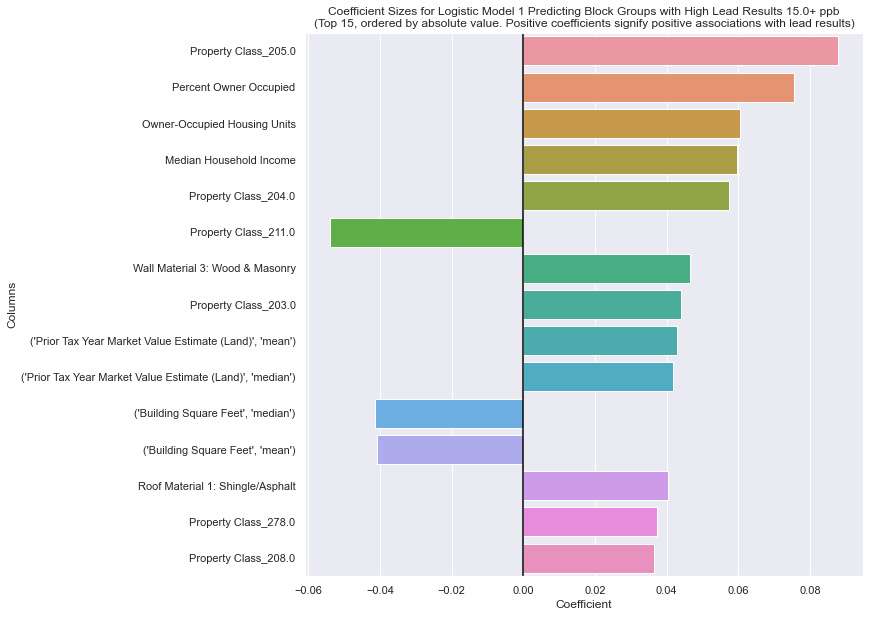

In [208]:
coef = (pd.DataFrame(best_model_high.coef_.reshape(-1,1))
        .rename(columns={0:'Coefficient'})
        .join(pd.Series(training_high_x.columns).rename('Columns')))
coef['Abs'] = abs(coef['Coefficient'])
coef = coef.sort_values('Abs', ascending=False).iloc[0:15]
coef.replace({
    'perc_owner_occ': 'Percent Owner Occupied', 
    'oo_hsng_units': 'Owner-Occupied Housing Units', 
    'med_income': 'Median Household Income', 
    'Wall Material_3.0': 'Wall Material 3: Wood & Masonry', 
    'Roof Material_1.0': 'Roof Material 1: Shingle/Asphalt'
}, inplace=True)

plt.figure(figsize=(10,10))
sns.barplot(data=coef, x='Coefficient', y='Columns')
plt.title('Coefficient Sizes for Logistic Model 1 Predicting Block Groups with High Lead Results 15.0+ ppb' + 
         '\n(Top 15, ordered by absolute value. Positive coefficients signify positive associations with lead results)')
# plt.plot(0, "-")
plt.axvline(x=0, ymin=0, ymax=1, color='black')
plt.show()

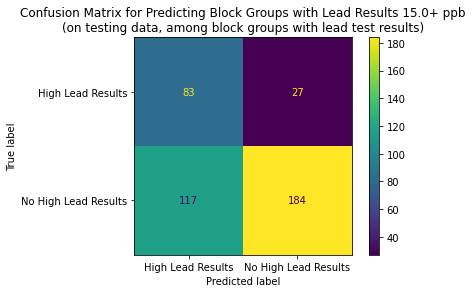


Test Accuracy: 0.6496
Test Precision: 0.415
Test Recall: 0.7545



In [57]:
cm = plot_confusion_matrix(
    estimator=best_model_high, 
    X=test_high_x, y_true=test_high_y, labels=[1,0], 
    display_labels=['High Lead Results', 'No High Lead Results'])
plt.grid(linestyle='')
plt.title('Confusion Matrix for Predicting Block Groups with Lead Results 15.0+ ppb\n' + 
         '(on testing data, among block groups with lead test results)')
plt.show()

accuracy = accuracy_score(y_true=test_high_y, y_pred=best_model_high.predict(test_high_x))
precision = precision_score(y_true=test_high_y, y_pred=best_model_high.predict(test_high_x))
recall = recall_score(y_true=test_high_y, y_pred=best_model_high.predict(test_high_x))

print(f'''
Test Accuracy: {round(accuracy, 4)}
Test Precision: {round(precision, 4)}
Test Recall: {round(recall, 4)}
''')

## Logistic Classification of Medium (5.0+) Lead PBB Test Results

In [60]:
grid_model_med = GridSearchCV(estimator=pipe, 
                          param_grid=params, 
                          cv=10, 
                          scoring=['accuracy', 'precision', 'recall'], 
                          refit='recall')
grid_model_med_result = grid_model_med.fit(training_med_x, training_med_y)

In [61]:
p_med = grid_model_med_result.best_params_
test_score = grid_model_med_result.score(
    X=test_med_x,
    y=test_med_y)
print(f'''
The best model was a Logistic Regression with the following parameters: 
C: {p_med['LogisticRegression__C']}
Penalty: {p_med['LogisticRegression__penalty']}
Solver: {p_med['LogisticRegression__solver']}
Class Weight: {p_med['LogisticRegression__class_weight']}

It had a mean validation set recall of {round(grid_model_med.best_score_, 4)}.
On the test data it had a recall of {round(test_score, 4)}.

This model is index #{grid_model_med_result.best_index_} in the below table. 
''')
results_med_df = (pd.DataFrame.from_dict(grid_model_med_result.cv_results_)[[
    'param_LogisticRegression__C', 'param_LogisticRegression__penalty',
    'param_LogisticRegression__solver', 'param_LogisticRegression__class_weight', 
    'mean_test_accuracy', 'rank_test_accuracy', 'mean_test_precision', 
    'rank_test_precision', 'mean_test_recall', 'rank_test_recall'
]].rename(columns={
    'param_LogisticRegression__C': 'C', 'param_LogisticRegression__penalty': 'penalty', 
    'param_LogisticRegression__solver': 'solver', 
    'param_LogisticRegression__class_weight': 'class_weight'}))
# Gets rid of models where the solvers and params are incompatible
results_med_df.dropna(axis=0, subset=['mean_test_accuracy']) 


The best model was a Logistic Regression with the following parameters: 
C: 0.01
Penalty: l1
Solver: liblinear
Class Weight: None

It had a mean validation set recall of 0.9771.
On the test data it had a recall of 0.9799.

This model is index #61 in the below table. 



,C,penalty,solver,class_weight,mean_test_accuracy,rank_test_accuracy,mean_test_precision,rank_test_precision,mean_test_recall,rank_test_recall
1,1000,l1,liblinear,None,0.808769,17,0.838372,46,0.920618,16
2,1000,l2,lbfgs,None,0.808769,17,0.837816,47,0.921438,6
3,1000,l2,liblinear,None,0.808769,17,0.837816,47,0.921438,6
4,1000,none,lbfgs,None,0.809379,10,0.838428,39,0.921438,6
7,1000,l1,liblinear,balanced,0.739978,42,0.896241,17,0.736539,35
8,1000,l2,lbfgs,balanced,0.739982,40,0.896266,15,0.736539,35
9,1000,l2,liblinear,balanced,0.739982,40,0.896266,15,0.736539,35
10,1000,none,lbfgs,balanced,0.737550,43,0.893492,20,0.735726,40
13,100,l1,liblinear,None,0.810595,1,0.840247,30,0.920618,16
14,100,l2,lbfgs,None,0.809989,2,0.839626,35,0.920618,16


In [68]:
best_model_med = LogisticRegression(
    C=p_med['LogisticRegression__C'], 
    penalty=p_med['LogisticRegression__penalty'], 
    solver=p_med['LogisticRegression__solver'], 
    class_weight=p_med['LogisticRegression__class_weight'], 
    max_iter=5000)
best_model_med.fit(X=training_med_x, y=training_med_y)
pipeline.print_coefs(
    best_model_med, df=training.drop(columns=['threshold_high']), 
    target='threshold_medium', n=100)

Target:
threshold_medium

Intercept:
[0.81210113]

Features and Coefficients:
Roof Material_1.0                                                0.297822
perc_owner_occ                                                   0.182151
('Prior Tax Year Market Value Estimate (Land)', 'median')        0.058444
Repair Condition_2.0                                             0.031082
Property Class_203.0                                             0.021430
Property Class_205.0                                             0.008540
Property Class_212.0                                             0.000000
Property Class_234.0                                             0.000000
Property Class_241.0                                             0.000000
Property Class_278.0                                             0.000000
Wall Material_4.0                                                0.000000
Property Class_295.0                                             0.000000
Property Class_299.0              

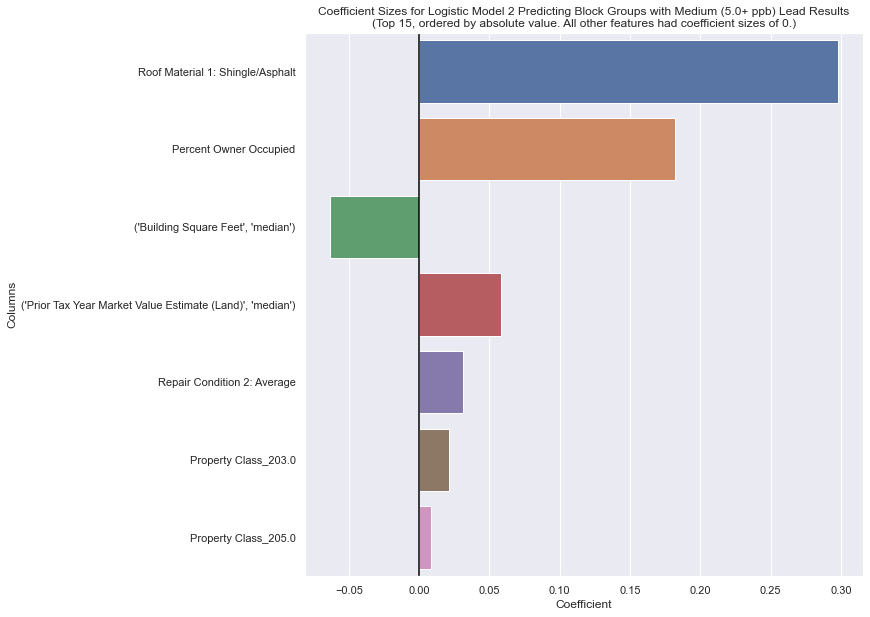

In [209]:
coef = (pd.DataFrame(best_model_med.coef_.reshape(-1,1))
        .rename(columns={0:'Coefficient'})
        .join(pd.Series(training_med_x.columns).rename('Columns')))
coef['Abs'] = abs(coef['Coefficient'])
coef = coef.sort_values('Abs', ascending=False).iloc[0:9]
# This model was highly regularized, so most coefficients are 0. 
coef = coef[coef['Abs'] != 0] 
coef.replace({
    'perc_owner_occ': 'Percent Owner Occupied', 
    'oo_hsng_units': 'Owner-Occupied Housing Units', 
    'med_income': 'Median Household Income', 
    'Wall Material_3.0': 'Wall Material 3: Wood & Masonry', 
    'Roof Material_1.0': 'Roof Material 1: Shingle/Asphalt', 
    'Repair Condition_2.0': 'Repair Condition 2: Average'
}, inplace=True)
plt.figure(figsize=(10,10))
sns.barplot(data=coef, x='Coefficient', y='Columns')
plt.title('Coefficient Sizes for Logistic Model 2 Predicting Block Groups with Medium (5.0+ ppb) Lead Results' + 
         '\n(Top 15, ordered by absolute value. All other features had coefficient sizes of 0.)')
plt.axvline(x=0, ymin=0, ymax=1, color='black')
plt.show()

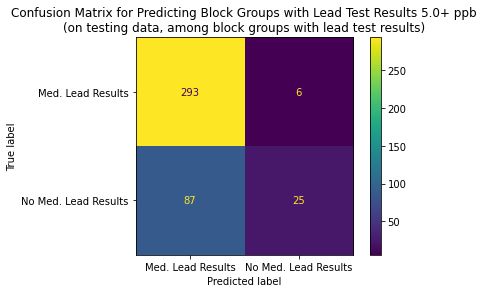


Test Accuracy: 0.7737
Test Precision: 0.7711
Test Recall: 0.9799



In [69]:
plot_confusion_matrix(
    estimator=best_model_med, 
    X=test_med_x, y_true=test_med_y, labels=[1,0], 
    display_labels=['Med. Lead Results', 'No Med. Lead Results'])
plt.grid(linestyle='')
plt.title('Confusion Matrix for Predicting Block Groups with Lead Test Results 5.0+ ppb\n' + 
         '(on testing data, among block groups with lead test results)')
plt.show()

accuracy = accuracy_score(y_true=test_med_y, y_pred=best_model_med.predict(test_med_x))
precision = precision_score(y_true=test_med_y, y_pred=best_model_med.predict(test_med_x))
recall = recall_score(y_true=test_med_y, y_pred=best_model_med.predict(test_med_x))

print(f'''
Test Accuracy: {round(accuracy, 4)}
Test Precision: {round(precision, 4)}
Test Recall: {round(recall, 4)}
''')

## Multinomial Specification

In [7]:
group = (
    water_classification['threshold_high'].astype('str') + 
    water_classification['threshold_medium'].astype('str')
        .rename('Count'))
water_classification['threshold_cat'] = group.replace(to_replace={'00': 0, '01': 1, '11': 2})

training, test = train_test_split(
    water_classification, test_size=0.2, random_state=0)
training_cat_x, training_cat_y = (
    training.drop(columns=['threshold_high', 'threshold_medium', 'threshold_cat']),
    training['threshold_cat'])
test_cat_x, test_cat_y = (
    test.drop(columns=['threshold_high', 'threshold_medium', 'threshold_cat']), 
    test['threshold_cat'])

In [8]:
precision_scorer = make_scorer(precision_score, average='weighted')
recall_scorer = make_scorer(recall_score, average='weighted')

In [9]:
grid_model_cat = GridSearchCV(estimator=pipe, 
                          param_grid=params, 
                          cv=10, 
                          scoring = {'accuracy': make_scorer(accuracy_score), 
                                     'precision': make_scorer(precision_score, average='weighted'), 
                                     'recall': make_scorer(recall_score, average='weighted')}, 
                          refit='recall')

grid_model_cat_result = grid_model_cat.fit(training_cat_x, training_cat_y)

In [10]:
p_cat = grid_model_cat_result.best_params_
test_score = grid_model_cat_result.score(
    X=test_cat_x,
    y=test_cat_y)
print(f'''
The best model was a Logistic Regression with the following parameters: 
C: {p_cat['LogisticRegression__C']}
Penalty: {p_cat['LogisticRegression__penalty']}
Solver: {p_cat['LogisticRegression__solver']}
Class Weight: {p_cat['LogisticRegression__class_weight']}

It had a mean validation set recall of {round(grid_model_cat.best_score_, 4)}.
On the test data it had a recall of {round(test_score, 4)}.

This model is index #{grid_model_cat_result.best_index_} in the below table. 
''')
results_cat_df = (pd.DataFrame.from_dict(grid_model_cat_result.cv_results_)[[
    'param_LogisticRegression__C', 'param_LogisticRegression__penalty',
    'param_LogisticRegression__solver', 'param_LogisticRegression__class_weight', 
    'mean_test_accuracy', 'rank_test_accuracy', 'mean_test_precision', 
    'rank_test_precision', 'mean_test_recall', 'rank_test_recall'
]].rename(columns={
    'param_LogisticRegression__C': 'C', 'param_LogisticRegression__penalty': 'penalty', 
    'param_LogisticRegression__solver': 'solver', 
    'param_LogisticRegression__class_weight': 'class_weight'}))
# Gets rid of models where the solvers and params are incompatible
results_cat_df.dropna(axis=0, subset=['mean_test_accuracy']) 


The best model was a Logistic Regression with the following parameters: 
C: 0.1
Penalty: l2
Solver: lbfgs
Class Weight: None

It had a mean validation set recall of 0.5841.
On the test data it had a recall of 0.5693.

This model is index #50 in the below table. 



,C,penalty,solver,class_weight,mean_test_accuracy,rank_test_accuracy,mean_test_precision,rank_test_precision,mean_test_recall,rank_test_recall
1,1000,l1,liblinear,None,0.578585,16,0.576422,21,0.578585,16
2,1000,l2,lbfgs,None,0.582849,5,0.579992,6,0.582849,5
3,1000,l2,liblinear,None,0.576755,22,0.574547,24,0.576755,22
4,1000,none,lbfgs,None,0.581630,7,0.578864,9,0.581630,7
7,1000,l1,liblinear,balanced,0.549339,28,0.547578,31,0.549339,28
8,1000,l2,lbfgs,balanced,0.518300,43,0.531285,43,0.518300,43
9,1000,l2,liblinear,balanced,0.549335,29,0.547664,30,0.549335,29
10,1000,none,lbfgs,balanced,0.518300,43,0.530924,44,0.518300,43
13,100,l1,liblinear,None,0.578581,17,0.576502,19,0.578581,17
14,100,l2,lbfgs,None,0.583459,3,0.579997,5,0.583459,3


In [11]:
best_model_cat = LogisticRegression(
    C=p_cat['LogisticRegression__C'], 
    penalty=p_cat['LogisticRegression__penalty'], 
    solver=p_cat['LogisticRegression__solver'], max_iter=5000)
best_model_cat.fit(X=training_cat_x, y=training_cat_y)

LogisticRegression(C=0.1, max_iter=5000)

In [12]:
coef = (pd.DataFrame(best_model_cat.coef_.T)
        .join(pd.Series(training_cat_x.columns).rename('Features')))
coef['Abs'] = abs(coef[0]) + abs(coef[1]) + abs(coef[2])
coef.sort_values('Abs', ascending=False, inplace=True)
coef.rename(columns={0: 'Low Lead Category', 1: 'Medium Lead Category', 2: 'High Lead Category'}, inplace=True)
coef.replace({
    'perc_owner_occ': 'Percent Owner Occupied', 
    'oo_hsng_units': 'Owner-Occupied Housing Units', 
    'med_income': 'Median Household Income', 
    'Wall Material_3.0': 'Wall Material 3: Wood & Masonry', 
    'Roof Material_1.0': 'Roof Material 1: Shingle/Asphalt', 
    'tot_pop': 'Total Population'
}, inplace=True)
coef.iloc[0:15]
# Negative values indicate that the features are less associated with that particular 
# class. The class are: 
# 0 - Block Group has no lead tests results at or above 5.0 ppb
# 1 - Block Group has lead tests results between 5.0 and 15.0 ppb, and no higher results
# 2 - Block Group has lead test results above 15.0 ppb

,Low Lead Category,Medium Lead Category,High Lead Category,Features,Abs
9,-0.463392,0.122348,0.341044,Total Population,0.926784
13,0.298480,-0.113896,-0.184584,('Prior Tax Year Market Value Estimate (Buildi...,0.596959
8,-0.296097,0.147656,0.148441,Percent Owner Occupied,0.592194
0,0.295243,-0.066818,-0.228425,hh_size,0.590486
26,-0.292331,0.055058,0.237273,Property Class_205.0,0.584662
34,-0.262386,0.122769,0.139616,Property Class_234.0,0.524771
14,-0.246868,0.110057,0.136811,('Prior Tax Year Market Value Estimate (Buildi...,0.493736
4,0.112633,-0.224183,0.111550,Owner-Occupied Housing Units,0.448366
32,0.212040,-0.058497,-0.153543,Property Class_211.0,0.424080
36,-0.205250,0.120129,0.085121,Property Class_278.0,0.410501


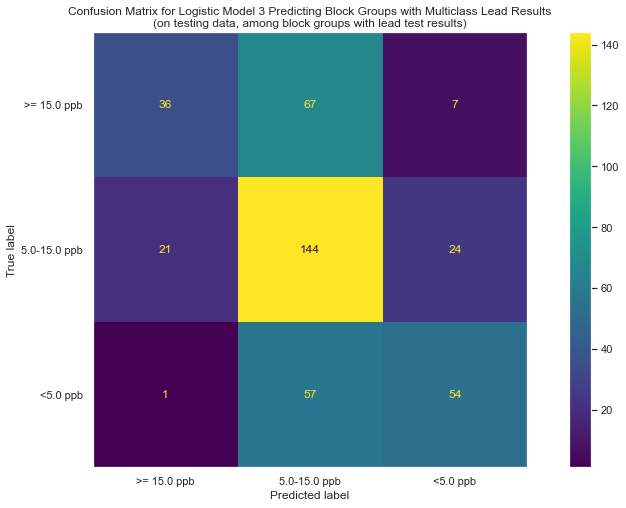


Test Accuracy: 0.5693
Test Precision (weighted by true values): 0.5863
Test Recall (weighted by true values): 0.5693



In [18]:
sns.set(rc={'figure.figsize':(15, 8)})
cm = plot_confusion_matrix(
    estimator=best_model_cat, 
    X=test_cat_x, y_true=test_cat_y, labels=[2, 1, 0], 
    display_labels=['>= 15.0 ppb', '5.0-15.0 ppb', '<5.0 ppb'])
plt.grid(linestyle='')
plt.title('Confusion Matrix for Logistic Model 3 Predicting Block Groups with Multiclass Lead Results\n' + 
         '(on testing data, among block groups with lead test results)')
plt.show()

accuracy = accuracy_score(y_true=test_cat_y, y_pred=best_model_cat.predict(test_cat_x))
precision = precision_score(y_true=test_cat_y, y_pred=best_model_cat.predict(test_cat_x), average='weighted')
recall = recall_score(y_true=test_cat_y, y_pred=best_model_cat.predict(test_cat_x), average='weighted')

print(f'''
Test Accuracy: {round(accuracy, 4)}
Test Precision (weighted by true values): {round(precision, 4)}
Test Recall (weighted by true values): {round(recall, 4)}
''')

In [25]:
final_mapping_df = gpd.read_file('data/final_mapping_df.shp')
final_assessments = pd.read_csv('data/final_assessments_block_group.csv', index_col=0, sep='\t')
final_assessments['GEOID'] = final_assessments['GEOID'].astype('str')
final_mapping_df = pd.merge(final_mapping_df, final_assessments[['GEOID']], 
                            left_on='GEOID', right_on='GEOID', how='inner')
scaler = pipeline.normalized_values(
    final_mapping_df, 
    quiet=True)
final_mapping_df = pipeline.normalize(
    final_mapping_df, scaler, 
    inplace=True)

final_mapping_df['predictions_cat'] = (best_model_cat.predict(
    X=final_mapping_df.drop(
        columns=['threshold_', 'threshol_1', 'GEOID', 'geometry']))
    .astype('str'))

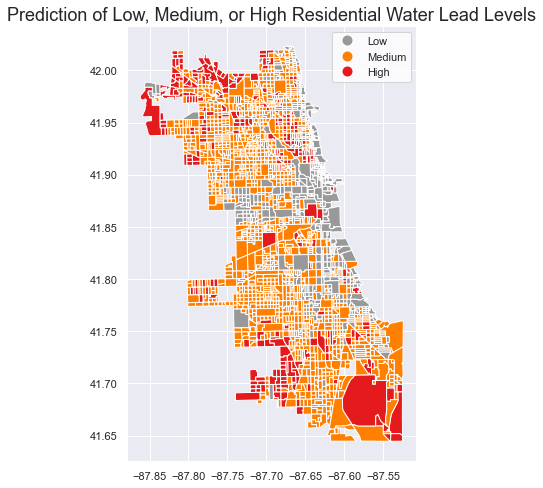

In [26]:
fig, ax = plt.subplots(1, 1)
sns.set(rc={'figure.figsize':(30, 15)})
sns.set_theme(style="white")
lead_map = final_mapping_df.plot(column='predictions_cat', legend=True, ax=ax, cmap='Set1_r')
plt.title('Prediction of Low, Medium, or High Residential Water Lead Levels', 
         fontsize=18)
leg = ax.get_legend()
leg.get_texts()[0].set_text('Low')
leg.get_texts()[1].set_text('Medium')
leg.get_texts()[2].set_text('High')
plt.show()